In [0]:
!pip install numpy
!pip install opencv-python

In [0]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (25.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/imagesv2/"

Dump_output		      out1.pdf_left_skewed_10.jpg
Extracted_csv		      out1.pdf_right_skewed8.JPG
out1.pdf_180+rot+scaled.jpg   out1.pdf_rot+scaled.jpg
out1.pdf_90+white_border.jpg  out1.pdf_scaled_80.jpg
out1.pdf_border_black.jpg     out1.pdf_yellowed.jpg


In [0]:
import os
os.getcwd()
path = '/content/drive/My Drive/imagesv2/'
os.chdir(path)
os.getcwd()

'/content/drive/My Drive/imagesv2'

In [0]:
import cv2
import numpy as np
import re

In [0]:
# For code to work on Colab

import matplotlib.pyplot as plt
%matplotlib inline
import pytesseract
from pytesseract.pytesseract import TesseractError

In [0]:
def display(image, fx=1, fy=1):
    """Function to display image
    :param image: Input image
    :param fx: Scale factor of x-axis
    :param fy: Scale factor of y-axis
    """
    image = cv2.resize(image, (0, 0), fx=fx, fy=fy)
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def detect_orientation(image):
    """ Returns correct oriented image
    :param image: Input image
    """
    custom_oem_psm_config = r'--oem 1--psm 7'
    newdata = pytesseract.image_to_osd(image,config= custom_oem_psm_config)
    rotation = int(re.search('(?<=Rotate: )\\d+', newdata).group(0))
    # print("Rotation degrees : ", rotation)
    return rotate_img(image, rotation)


def rotate_img(image, degrees):
    """Returns image rotated to the angle provided by detect_orientation
    :param image: The input image
    :param degrees: Angle to rotate
    :return Corrected image
    """
    if degrees == 90:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif degrees == 180:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif degrees == 270:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif degrees == 0:
        return image
    else:
        print("DEGREE = ", degrees)


def straighten(image):
    """Applies straighten to an image
    :param image : Input image
    :return Straightened image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # print("Straightening angle : ", angle)
    return rotated


def straighten_thresh(image):
    """Applies straighten to an image
    :param image : Input threshold image
    :return Straightened image
    """
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # print("Straightening angle : ", angle)
    return rotated


In [0]:

def extract_image(image):
  """
  Returns borderless image
  :param image : Image with border
  :returns borderless image
  """
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  re, img = cv2.threshold(img,160, 255, cv2.THRESH_BINARY)
  cont, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  area = 0
  biggest_cont = cont[0][0]
  peri = cv2.approxPolyDP(cont[0][0], 0.1, False)

  for i in cont:
      area1 = cv2.contourArea(i)
      if area1 > area:
          peri = cv2.approxPolyDP(i, 0.1, True)
          area = area1
          biggest_cont = i

  mask = np.zeros((image.shape[0], image.shape[1]),dtype=np.uint8)
  cv2.drawContours(mask, [biggest_cont], -1,(255,255,255),thickness=0)
  sub_image = img - mask
  st_sub_images = straighten_thresh(sub_image)
  thresh = cv2.threshold(st_sub_images,1,255,cv2.THRESH_BINARY)[1]
  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  if len(contours) == 1:
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    st_sub_images = st_sub_images[y:y+h,x:x+w]
  return st_sub_images

def plot_before_after(before, after):
    """
    :param before: Before correction image
    :param after: After correction image
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16, 22))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    plt.grid(True)
    plt.title(label="Before : ")

    plt.subplot(1, 2, 2)
    plt.imshow(after, cmap='Greys_r')
    # plt.axis('off')
    plt.grid(True)
    plt.title(label='After : ')
    plt.show()


In [0]:
def detect_border_color(img):
    # img = cv2.threshold((cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)),127,255,cv2.THRESH_BINARY)[1]
    l,b = img.shape
    PERCENTAGE = 3
    l = (l*PERCENTAGE)//100
    b = (b*PERCENTAGE)//100
    # print(l,b)
    c1 = img[:,:b]
    c2 = img[:l,:]
    # display(c1)
    # display(c2)
    values1, counts1 = np.unique(c1, return_counts=True)
    values2, counts2 = np.unique(c2, return_counts=True)
    if values1[np.argmax(counts1)] == values2[np.argmax(counts2)]:
        # print(type(values1[np.argmax(counts1)]))
        return values1[np.argmax(counts1)]
    else:
        print("Extra space exists")
        return None

def cropped(img_gray,value):
    # img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # img_gray = cv2.threshold(img_gray,127,255,type = cv2.THRESH_BINARY)[1]
    # print(type(img_gray),img_gray.shape)
    # print(img_gray)
    # display(img_gray,0.35,0.35)
    cont_x = [i for i in range(img_gray.shape[0]) if set(img_gray[i]) != {value}]
    first_x,last_x =cont_x[0],cont_x[-1]

    img_gray_trans = np.transpose(img_gray)
    cont_y = [i for i in range(img_gray_trans.shape[0]) if set(img_gray_trans[i]) != {value}]
    first_y,last_y =cont_y[0],cont_y[-1]

    img_cropped : np.ndarray = img_gray[first_x:last_x,first_y:last_y]
    # print(img_cropped.shape)
    return img_cropped

# value = border_color(img)
# img2 = cropped(img,value)
# display(img2,0.35,0.35)
# value = border_color(img2)
# display(cropped(img2,value),0.35,0.35)



				################# out1.pdf_scaled_80.jpg ####################


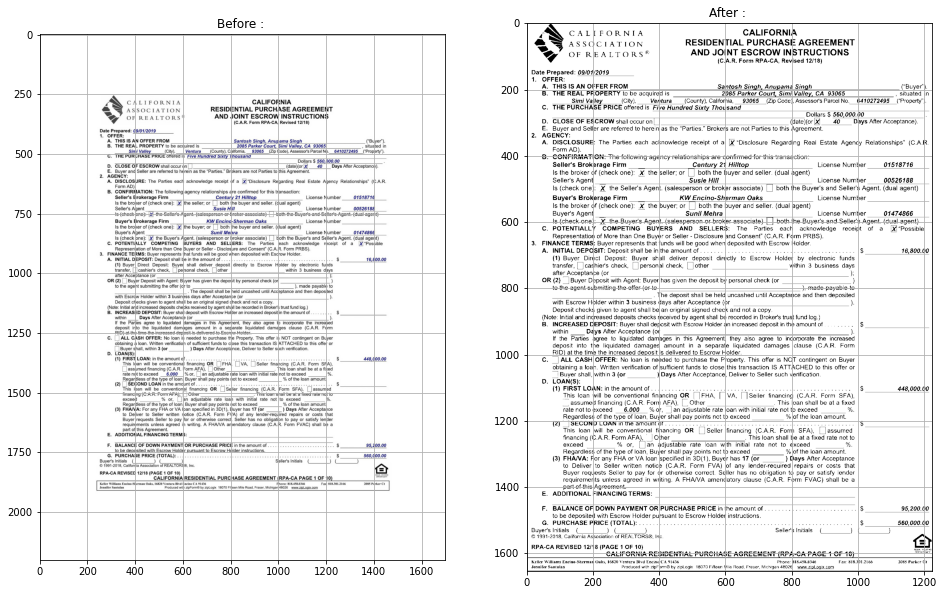



				################# out1.pdf_180+rot+scaled.jpg ####################


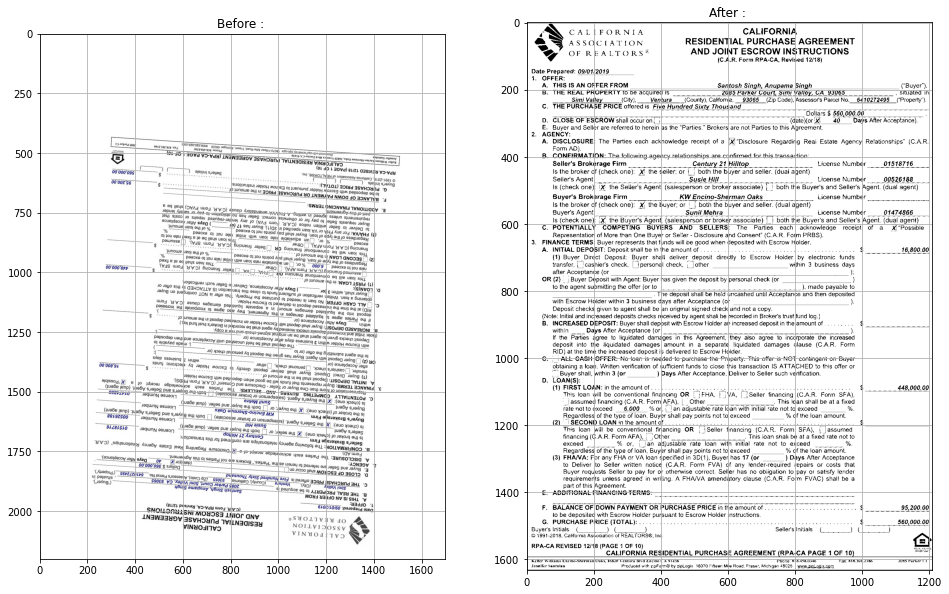



				################# out1.pdf_border_black.jpg ####################


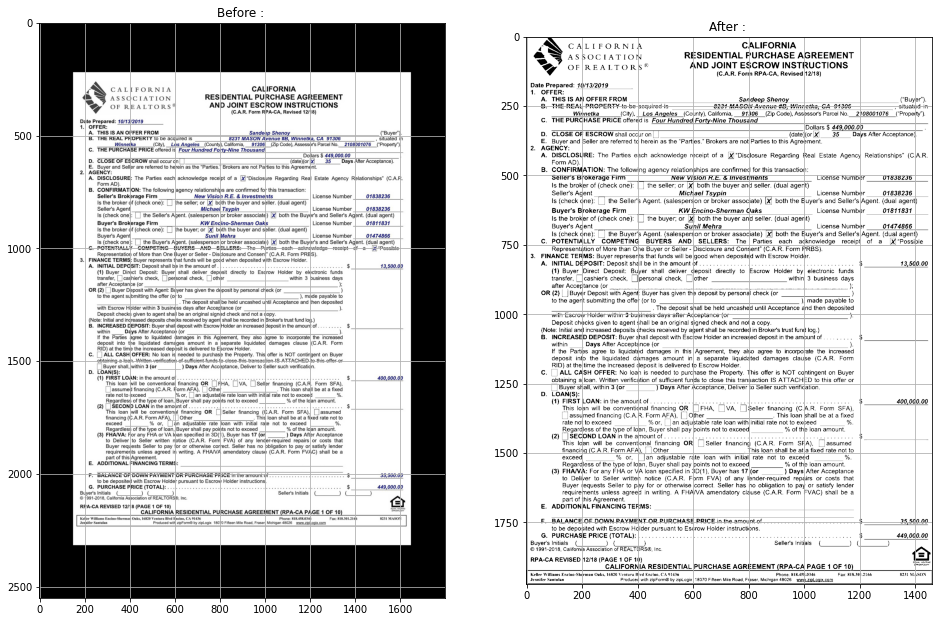



				################# out1.pdf_left_skewed_10.jpg ####################


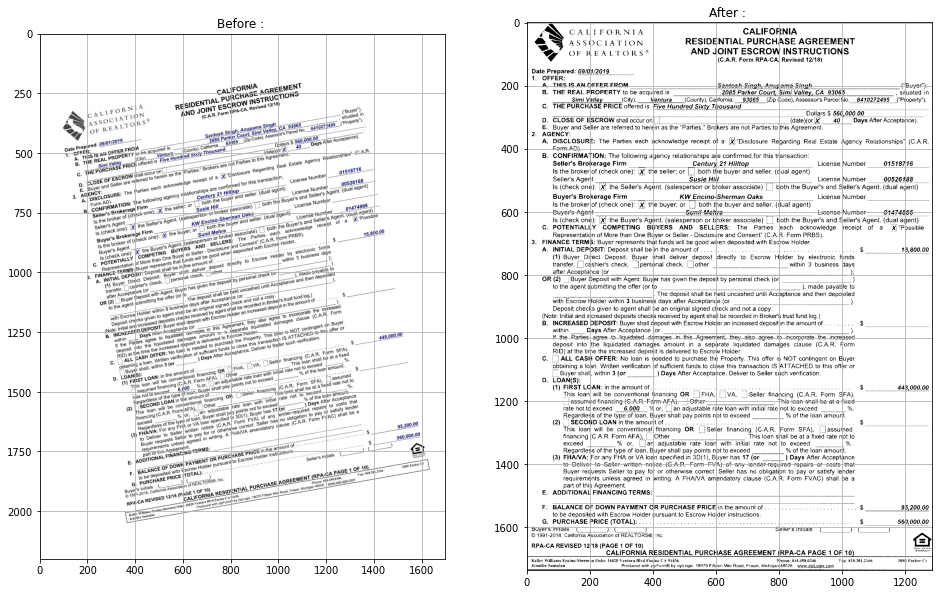



				################# out1.pdf_rot+scaled.jpg ####################


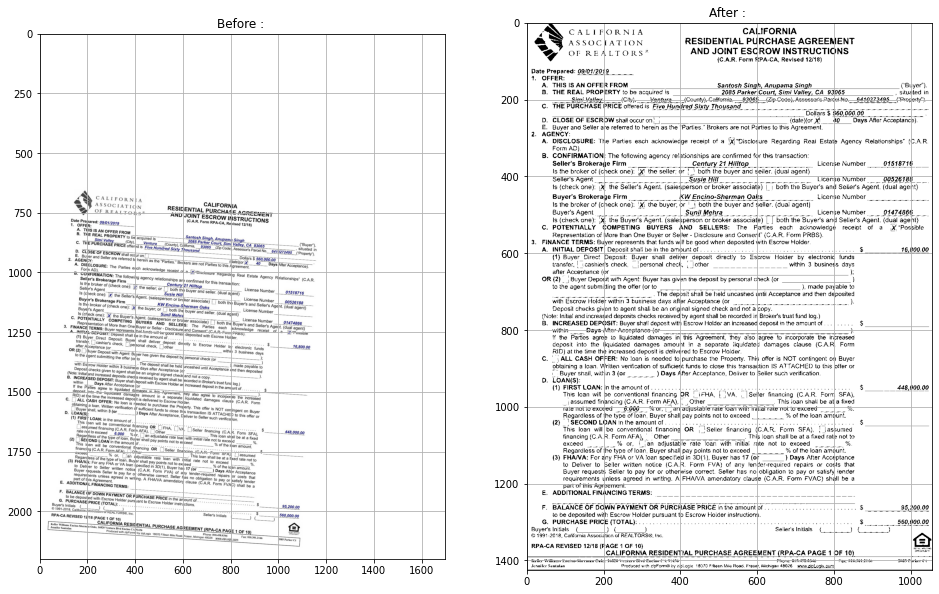



				################# out1.pdf_90+white_border.jpg ####################


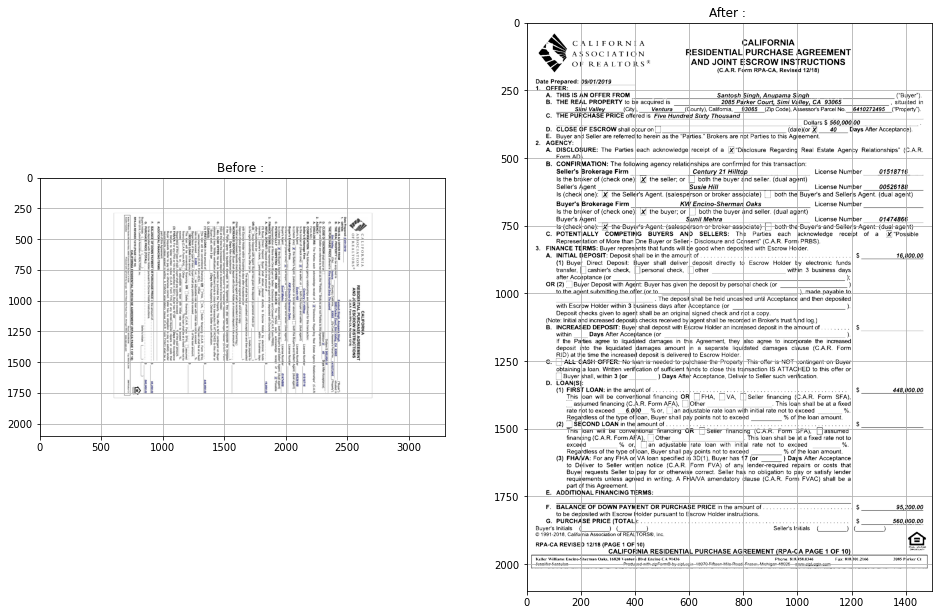



				################# out1.pdf_yellowed.jpg ####################


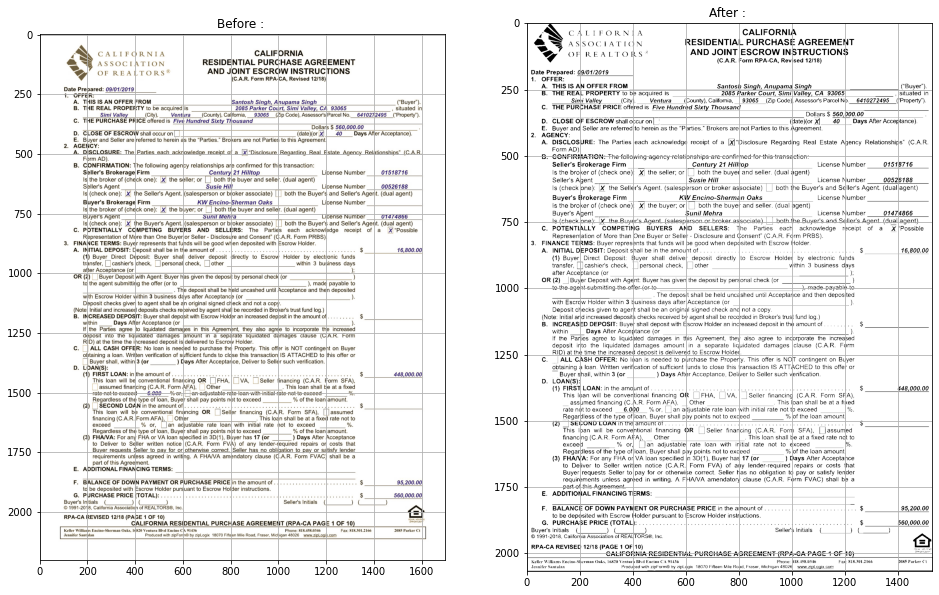

In [0]:
files = [f for f in os.listdir() if f[-4:] == '.jpg']
for image_name in files:
    image_before = cv2.imread(image_name)
    image = np.copy(image_before)
    flag = False
    try:
        image = detect_orientation(image)
    except TesseractError as e:
        print('Exception raised ',e.message)
        flag = True
    image = straighten(image)
    image = extract_image(image) # GENERATES BINARY IMAGE
    if flag:
        image = detect_orientation(image)
        image = straighten_thresh(image)
    ### EXTRA SPACE ###
    value = detect_border_color(image)
    if value:
        image = cropped(image,value)
    print("\n\n\t\t\t\t################# " + image_name + " ####################")
    plot_before_after(image_before, image)